# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering


Sub-task 1: improve the feature’s predictive power and elaborate why you made those choices

Sub-task 2: build a predictive model to see how well these features are able to predict a customer churning

---

## 1. Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
from datetime import datetime, timedelta
import scipy.stats


import warnings
warnings.filterwarnings('ignore')

---
## 2. Load data

In [2]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23  ...   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31  ...   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   

   mean_3m_price_p1_var  mean_3m_price_p2_var  mean_3m_price_p3_var  \
0              0.131756              0.092638              0.036909   
1              0.147600              0.000000              0.000000   
2              0.167798              0.088409              0.000000   

   mean_3m_price_p1_fix  mean_3m_price_p2_fix  mean_3m_price_p3_fix  \
0             42.497907             12.218665              8.145777   
1             44.444710              0.000000              0.000000   
2             44.444710              0.000000              0.000000   

   mean_3m_price_p1 mean_3m_price_p2  mean_3m_price_p3  churn  
0         42.629663        12.311304          8.182687      1  
1         44.592310         0.000000          0.000000      0  
2         44.612508         0.088409          0.000000      0  

[3 rows x 54 columns]

In [4]:
df.shape

(14605, 54)

In [5]:
df.columns

Index(['Unnamed: 0', 'id', 'channel_sales', 'cons_12m', 'cons_gas_12m',
       'cons_last_month', 'date_activ', 'date_end', 'date_modif_prod',
       'date_renewal', 'forecast_cons_12m', 'forecast_cons_year',
       'forecast_discount_energy', 'forecast_meter_rent_12m',
       'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
       'forecast_price_pow_off_peak', 'has_gas', 'imp_cons',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max',
       'mean_year_price_p1_var', 'mean_year_price_p2_var',
       'mean_year_price_p3_var', 'mean_year_price_p1_fix',
       'mean_year_price_p2_fix', 'mean_year_price_p3_fix',
       'mean_year_price_p1', 'mean_year_price_p2', 'mean_year_price_p3',
       'mean_6m_price_p1_var', 'mean_6m_price_p2_var', 'mean_6m_price_p3_var',
       'mean_6m_price_p1_fix', 'mean_6m_price_p2_fix', 'mean_6m_price_p3_fix',
       'mean_6m_price_p1', 'mean_6m_price_p2', 'mean_6m_p

---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [6]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

id price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745 2015-01-01            0.151367   
1  038af19179925da21a25619c5a24b745 2015-02-01            0.151367   
2  038af19179925da21a25619c5a24b745 2015-03-01            0.151367   
3  038af19179925da21a25619c5a24b745 2015-04-01            0.149626   
4  038af19179925da21a25619c5a24b745 2015-05-01            0.149626   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   
3             0.0                 0.0           44.266931             0.0   
4             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [7]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

id  offpeak_diff_dec_january_energy  \
0  0002203ffbb812588b632b9e628cc38d                        -0.006192   
1  0004351ebdd665e6ee664792efc4fd13                        -0.004104   
2  0010bcc39e42b3c2131ed2ce55246e3c                         0.050443   
3  0010ee3855fdea87602a5b7aba8e42de                        -0.010018   
4  00114d74e963e47177db89bc70108537                        -0.003994   

   offpeak_diff_dec_january_power  
0                        0.162916  
1                        0.177779  
2                        1.500000  
3                        0.162916  
4                       -0.000001

In [8]:
df = pd.merge(df, diff, on='id')
df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23  ...   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31  ...   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31  ...   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09  ...   

   mean_3m_price_p3_var  mean_3m_price_p1_fix  mean_3m_price_p2_fix  \
0              0.036909             42.497907             12.218665   
1              0.000000             44.444710              0.000000   
2              0.000000             44.444710              0.000000   
3              0.000000             44.444710              0.000000   
4              0.073719             40.728885             24.437330   

   mean_3m_price_p3_fix  mean_3m_price_p1  mean_3m_price_p2  mean_3m_price_p3  \
0              8.145777         42.629663         12.311304          8.182687   
1              0.000000         44.592310          0.000000          0.000000   
2              0.000000         44.612508          0.088409          0.000000   
3              0.000000         44.593296          0.000000          0.000000   
4             16.291555         40.848791         24.539003         16.365274   

  churn  offpeak_diff_dec_january_energy  offpeak_diff_dec_january_power  
0     1                         0.020057                        3.700961  
1     0                        -0.003767                        0.177779  
2     0                        -0.004670                        0.177779  
3     0                        -0.004547                        0.177779  
4     0                        -0.006192                        0.162916  

[5 rows x 56 columns]

### Average price changes across periods

In [9]:
# Aggregate average prices per period
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [10]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [11]:
columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  ...  mean_3m_price_p3  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23  ...          8.182687   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31  ...          0.000000   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...          0.000000   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31  ...          0.000000   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09  ...         16.365274   

   churn  offpeak_diff_dec_january_energy  offpeak_diff_dec_january_power  \
0      1                         0.020057                        3.700961   
1      0                        -0.003767                        0.177779   
2      0                        -0.004670                        0.177779   
3      0                        -0.004547                        0.177779   
4      0                        -0.006192                        0.162916   

   off_peak_peak_var_mean_diff  peak_mid_peak_var_mean_diff  \
0                     0.024038                     0.034219   
1                     0.142485                     0.007124   
2                     0.082090                     0.088421   
3                     0.151210                     0.000000   
4                     0.020536                     0.030773   

   off_peak_mid_peak_var_mean_diff off_peak_peak_fix_mean_diff  \
0                         0.058257                   18.590255   
1                         0.149609                   44.311375   
2                         0.170512                   44.385450   
3                         0.151210                   44.400265   
4                         0.051309                   16.275263   

   peak_mid_peak_fix_mean_diff  off_peak_mid_peak_fix_mean_diff  
0                     7.450670                        26.040925  
1                     0.000000                        44.311375  
2                     0.000000                        44.385450  
3                     0.000000                        44.400265  
4                     8.137629                        24.412893  

[5 rows x 62 columns]

We have now created features of mean average price differences across different time periods, which may reveal patterns between months

### Max price changes across periods and months

In [12]:
# Aggregate average prices per period
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [13]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [14]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [15]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23  ...   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31  ...   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31  ...   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09  ...   

   off_peak_mid_peak_var_mean_diff  off_peak_peak_fix_mean_diff  \
0                         0.058257                    18.590255   
1                         0.149609                    44.311375   
2                         0.170512                    44.385450   
3                         0.151210                    44.400265   
4                         0.051309                    16.275263   

   peak_mid_peak_fix_mean_diff  off_peak_mid_peak_fix_mean_diff  \
0                     7.450670                        26.040925   
1                     0.000000                        44.311375   
2                     0.000000                        44.385450   
3                     0.000000                        44.400265   
4                     8.137629                        24.412893   

   off_peak_peak_var_max_monthly_diff  peak_mid_peak_var_max_monthly_diff  \
0                            0.060550                            0.085483   
1                            0.151367                            0.085483   
2                            0.084587                            0.089162   
3                            0.153133                            0.000000   
4                            0.022225                            0.033743   

   off_peak_mid_peak_var_max_monthly_diff off_peak_peak_fix_max_monthly_diff  \
0                                0.146033                          44.266930   
1                                0.151367                          44.444710   
2                                0.172468                          44.444710   
3                                0.153133                          44.444710   
4                                0.055866                          16.291555   

   peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  
0                            8.145775                                44.26693  
1                            0.000000                                44.44471  
2                            0.000000                                44.44471  
3                            0.000000                                44.44471  
4                            8.145775                                24.43733  

[5 rows x 68 columns]

From customers' perspective, sudden price changes between months are annoying, and large increase in prices within a short period of times would be a factor in causing them to swtich to competitors. This would be a useful feature to predict churn

##### Loyalty (in years)

In [16]:
df['loyalty'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'Y')).astype(int)
df.groupby(['loyalty']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

churn
loyalty          
3        0.143836
2        0.133080
4        0.125756
13       0.095238
5        0.085425
12       0.083333
6        0.080713
7        0.073394
11       0.063584
8        0.048000
9        0.024096
10       0.020000

We can tell that customers who have only been a client for 4 or less months are much more likely to churn. The difference between 4 months and 5 months is around 4%, which indicates a jump in likelihood for customer to churn. So, getting customers to stay over 4 months can be a milestone.

### Transform dates into months

months_activ = Number of months active until reference date (2016)

months_end = Number of months of the contract left until reference date

months_modif_prod = Number of months since last modification until reference date

months_renewal = Number of months since last renewal until reference date


In [17]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [18]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [19]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0               0.00                   0                       0.0   
1             189.95                   0                       0.0   
2              47.96                   0                       0.0   
3             240.04                   0                       0.0   
4             445.75                 526                       0.0   

   forecast_meter_rent_12m  ...  peak_mid_peak_var_max_monthly_diff  \
0                     1.78  ...                            0.085483   
1                    16.27  ...                            0.085483   
2                    38.72  ...                            0.089162   
3                    19.83  ...                            0.000000   
4                   131.73  ...                            0.033743   

   off_peak_mid_peak_var_max_monthly_diff  off_peak_peak_fix_max_monthly_diff  \
0                                0.146033                           44.266930   
1                                0.151367                           44.444710   
2                                0.172468                           44.444710   
3                                0.153133                           44.444710   
4                                0.055866                           16.291555   

  peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  \
0                           8.145775                                44.26693   
1                           0.000000                                44.44471   
2                           0.000000                                44.44471   
3                           0.000000                                44.44471   
4                           8.145775                                24.43733   

   loyalty  months_activ  months_end  months_modif_prod  months_renewal  
0        3            30           5                  2               6  
1        7            76           7                 76               4  
2        6            68           3                 68               8  
3        6            69           2                 69               9  
4        6            71           2                 71               9  

[5 rows x 69 columns]

### Categorical data

##### has gas

In [20]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

churn
has_gas          
0        0.100544
1        0.081887

If a customer also buys gas from PowerCo, it shows that they have multiple products and are a loyal customer to the brand

##### channel_sales

In [21]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

There are three categories that have 11, 3, 2 occurences. Compared to the total of 14k rows, we can drop these three columns

In [22]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

Unnamed: 0                                id  cons_12m  cons_gas_12m  \
0           0  24011ae4ebbe3035111d65fa7c15bc57         0         54946   
1           1  d29c2c54acc38ff3c0614d0a653813dd      4660             0   
2           2  764c75f661154dac3a6c254cd082ea7d       544             0   
3           3  bba03439a292a1e166f80264c16191cb      1584             0   
4           4  149d57cf92fc41cf94415803a877cb4b      4425             0   

   cons_last_month  forecast_cons_12m  forecast_cons_year  \
0                0               0.00                   0   
1                0             189.95                   0   
2                0              47.96                   0   
3                0             240.04                   0   
4              526             445.75                 526   

   forecast_discount_energy  forecast_meter_rent_12m  \
0                       0.0                     1.78   
1                       0.0                    16.27   
2                       0.0                    38.72   
3                       0.0                    19.83   
4                       0.0                   131.73   

   forecast_price_energy_off_peak  ...  loyalty  months_activ  months_end  \
0                        0.114481  ...        3            30           5   
1                        0.145711  ...        7            76           7   
2                        0.165794  ...        6            68           3   
3                        0.146694  ...        6            69           2   
4                        0.116900  ...        6            71           2   

   months_modif_prod  months_renewal  channel_MISSING  \
0                  2               6                0   
1                 76               4                1   
2                 68               8                0   
3                 69               9                0   
4                 71               9                1   

   channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         0   
2                                         1   
3                                         0   
4                                         0   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   
3                                         1   
4                                         0   

  channel_usilxuppasemubllopkaafesmlibmsdf  
0                                        0  
1                                        0  
2                                        0  
3                                        0  
4                                        0  

[5 rows x 73 columns]

##### origin up

In [23]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

We will drop missing, and the last two columns

In [24]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

Unnamed: 0                                id  cons_12m  cons_gas_12m  \
0           0  24011ae4ebbe3035111d65fa7c15bc57         0         54946   
1           1  d29c2c54acc38ff3c0614d0a653813dd      4660             0   
2           2  764c75f661154dac3a6c254cd082ea7d       544             0   
3           3  bba03439a292a1e166f80264c16191cb      1584             0   
4           4  149d57cf92fc41cf94415803a877cb4b      4425             0   

   cons_last_month  forecast_cons_12m  forecast_cons_year  \
0                0               0.00                   0   
1                0             189.95                   0   
2                0              47.96                   0   
3                0             240.04                   0   
4              526             445.75                 526   

   forecast_discount_energy  forecast_meter_rent_12m  \
0                       0.0                     1.78   
1                       0.0                    16.27   
2                       0.0                    38.72   
3                       0.0                    19.83   
4                       0.0                   131.73   

   forecast_price_energy_off_peak  ...  months_modif_prod  months_renewal  \
0                        0.114481  ...                  2               6   
1                        0.145711  ...                 76               4   
2                        0.165794  ...                 68               8   
3                        0.146694  ...                 69               9   
4                        0.116900  ...                 71               9   

   channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                0                                         0   
1                1                                         0   
2                0                                         0   
3                0                                         0   
4                1                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         0   
2                                         1   
3                                         0   
4                                         0   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   
3                                         1   
4                                         0   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                           0   
1                                           1   
2                                           1   
3                                           1   
4                                           1   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                           1  
1                                           0  
2                                           0  
3                                           0  
4                                           0  

[5 rows x 75 columns]

### Deal with numerical data - skewedness

In [25]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  1.460500e+04  1.460500e+04     14605.000000       14605.000000   
mean   1.592303e+05  2.809108e+04     16091.371448        1868.638618   
std    5.734836e+05  1.629786e+05     64366.262314        2387.651549   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.674000e+03  0.000000e+00         0.000000         494.980000   
50%    1.411600e+04  0.000000e+00       793.000000        1112.610000   
75%    4.076400e+04  0.000000e+00      3383.000000        2402.270000   
max    6.207104e+06  4.154590e+06    771203.000000       82902.830000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14605.000000              14605.000000             14605.000000   
mean          1399.858747                  0.966450                63.090448   
std           3247.876793                  5.108355                66.166636   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                16.180000   
50%            314.000000                  0.000000                18.800000   
75%           1746.000000                  0.000000               131.030000   
max         175375.000000                 30.000000               599.310000   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14605.000000                14605.000000   
mean                         0.137282                    0.050488   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak  
count                 14605.000000  
mean                     43.130085  
std                       4.486140  
min                       0.000000  
25%                      40.606701  
50%                      44.311378  
75%                      44.311378  
max                      59.266378

In [26]:
# Apply log transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [27]:
df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  14605.000000  14605.000000     14605.000000       14605.000000   
mean       4.223945      0.778978         2.264801           2.962162   
std        0.884545      1.716828         1.769266           0.683612   
min        0.000000      0.000000         0.000000           0.000000   
25%        3.753966      0.000000         0.000000           2.695464   
50%        4.149742      0.000000         2.899821           3.046733   
75%        4.610287      0.000000         3.529430           3.380803   
max        6.792889      6.618528         5.887169           4.918575   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14605.000000              14605.000000             14605.000000   
mean             1.784733                  0.966450                 1.517233   
std              1.584972                  5.108355                 0.571489   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                 1.235023   
50%              2.498311                  0.000000                 1.296665   
75%              3.242293                  0.000000                 2.120673   
max              5.243970                 30.000000                 2.778376   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14605.000000                14605.000000   
mean                         0.137282                    0.050488   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak  
count                 14605.000000  
mean                     43.130085  
std                       4.486140  
min                       0.000000  
25%                      40.606701  
50%                      44.311378  
75%                      44.311378  
max                      59.266378

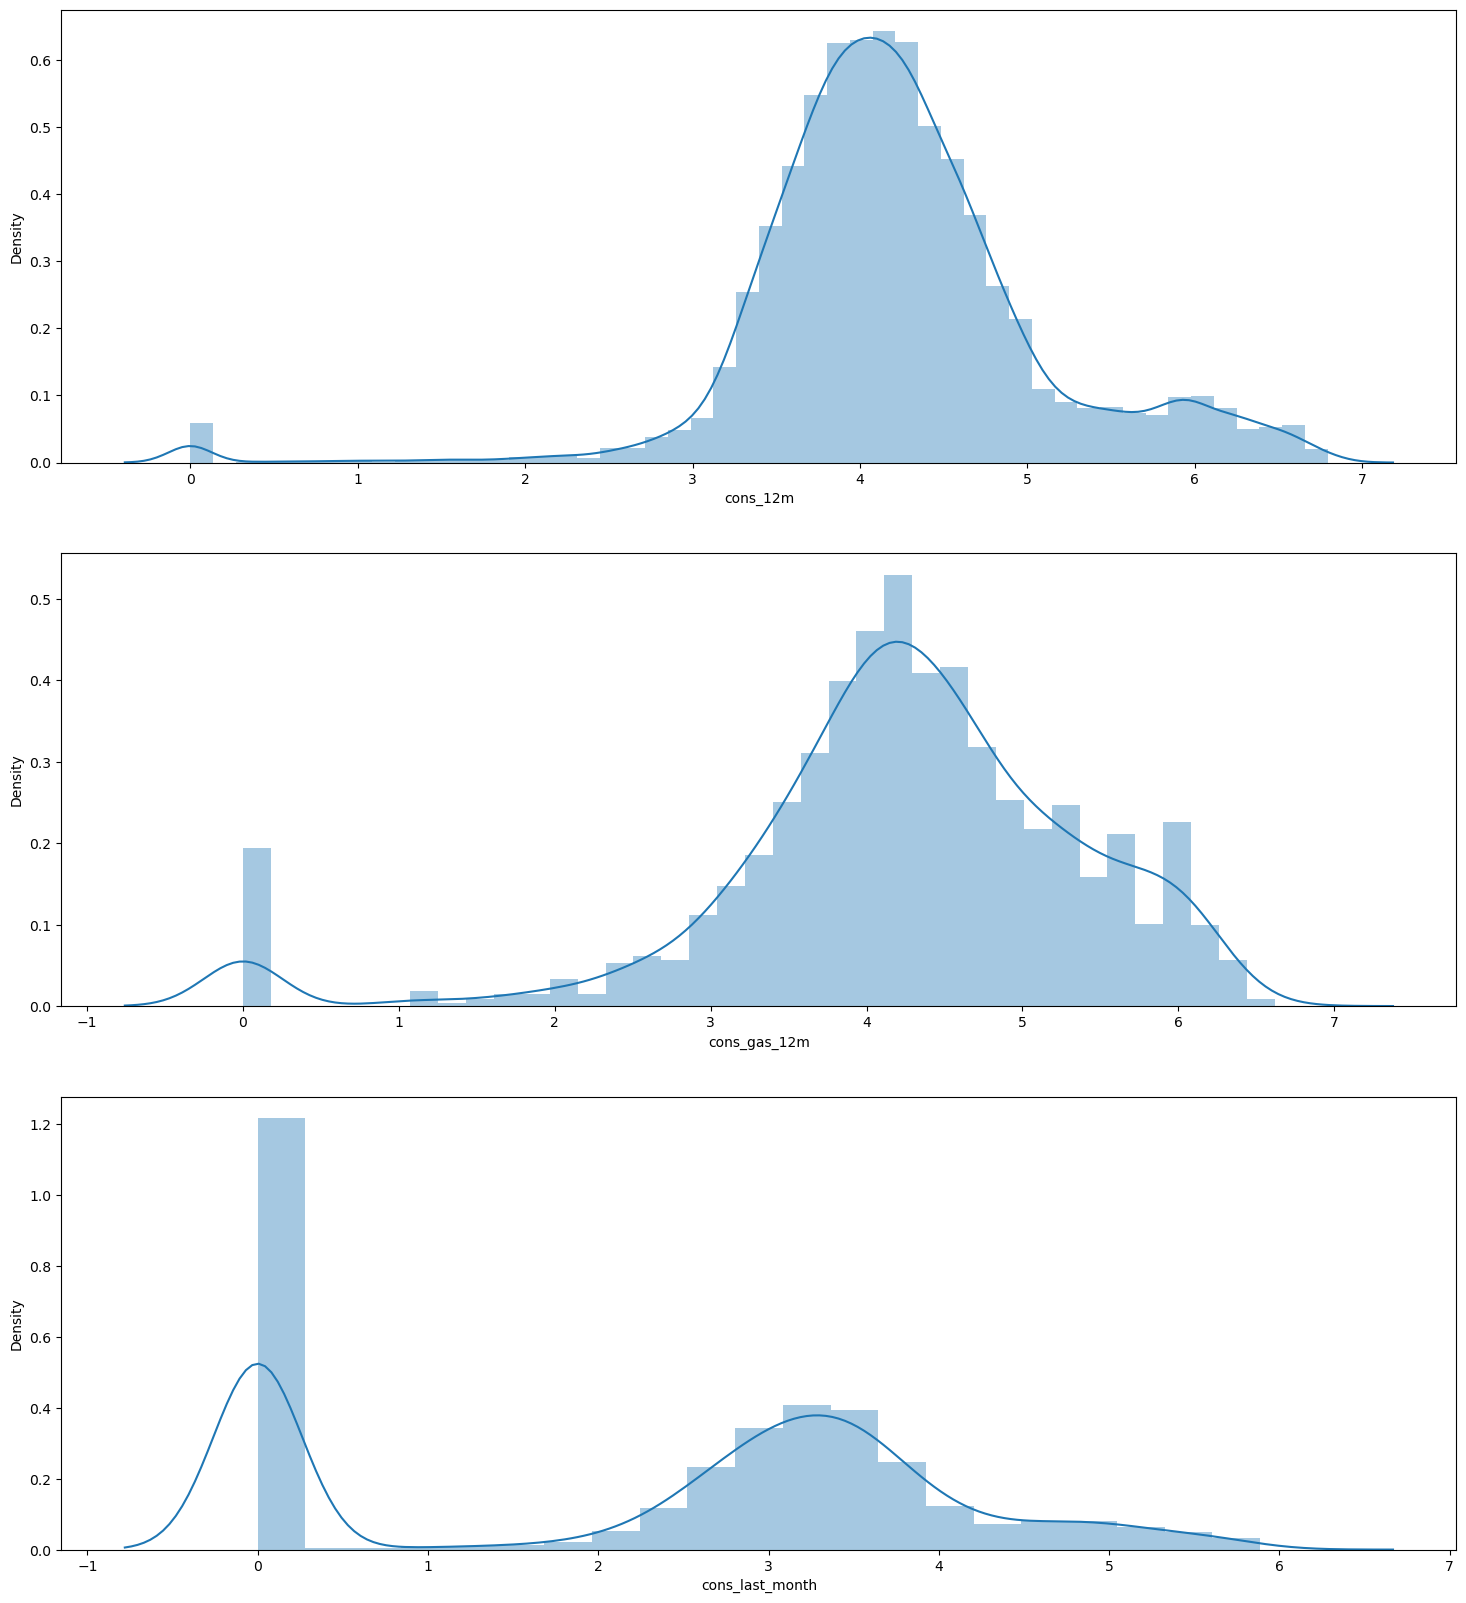

In [28]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

### Correlations (with churn)

In [29]:
correlation = df.corr()

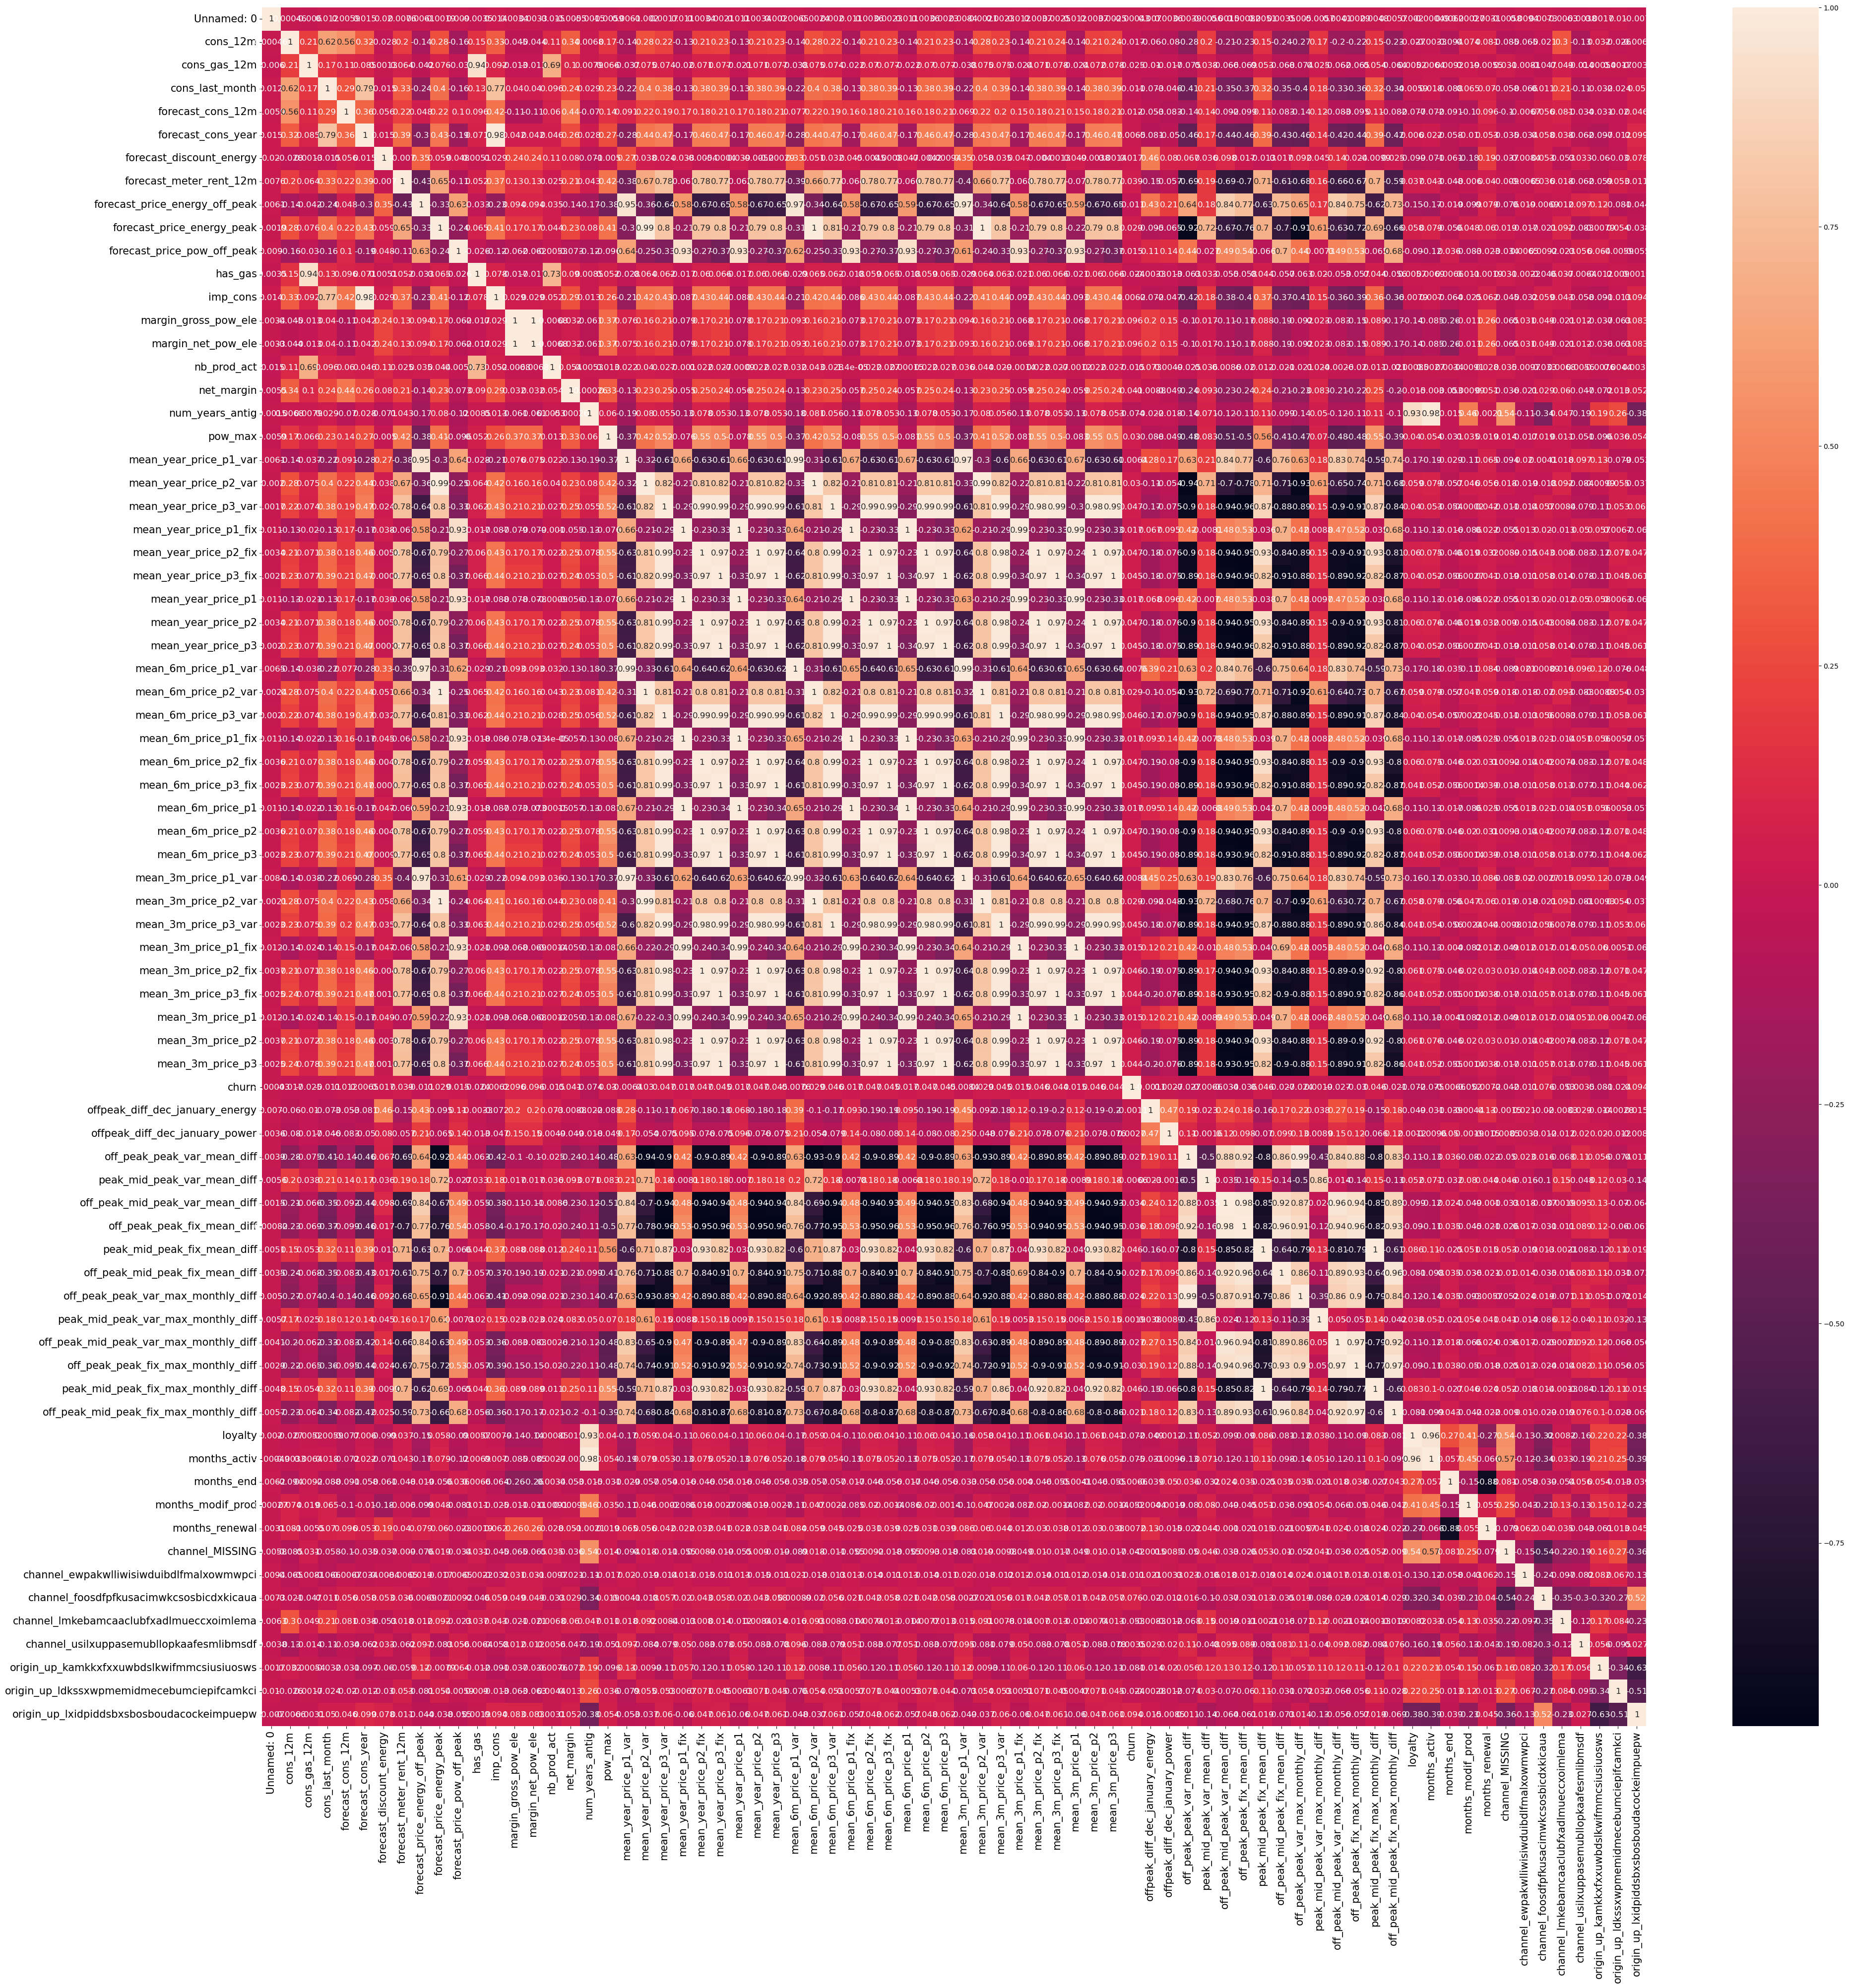

In [30]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

We will remove feature columns with a strong correlation (>0.9)

In [79]:
#Calculate the correlation coefficients
corr = df.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
raw = corr.loc[m, m]
raw.round(2).style.background_gradient(cmap='coolwarm')

In [50]:
print(df.columns.tolist())

['Unnamed: 0', 'id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'num_years_antig', 'pow_max', 'mean_year_price_p1_var', 'mean_year_price_p2_var', 'mean_year_price_p3_var', 'mean_year_price_p1_fix', 'mean_year_price_p2_fix', 'mean_year_price_p3_fix', 'mean_year_price_p1', 'mean_year_price_p2', 'mean_year_price_p3', 'mean_6m_price_p1_var', 'mean_6m_price_p2_var', 'mean_6m_price_p3_var', 'mean_6m_price_p1_fix', 'mean_6m_price_p2_fix', 'mean_6m_price_p3_fix', 'mean_6m_price_p1', 'mean_6m_price_p2', 'mean_6m_price_p3', 'mean_3m_price_p1_var', 'mean_3m_price_p2_var', 'mean_3m_price_p3_var', 'mean_3m_price_p1_fix', 'mean_3m_price_p2_fix', 'mean_3m_price_p3_fix', 'mean_3m_price_p1', 'mean_3m_price_p2', '

In [80]:
print(raw.columns.tolist())

['Unnamed: 0', 'cons_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'nb_prod_act', 'net_margin', 'pow_max', 'churn', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power', 'peak_mid_peak_var_mean_diff', 'peak_mid_peak_var_max_monthly_diff', 'months_end', 'months_modif_prod', 'months_renewal', 'channel_MISSING', 'channel_ewpakwlliwisiwduibdlfmalxowmwpci', 'channel_foosdfpfkusacimwkcsosbicdxkicaua', 'channel_lmkebamcaaclubfxadlmueccxoimlema', 'channel_usilxuppasemubllopkaafesmlibmsdf', 'origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws', 'origin_up_ldkssxwpmemidmecebumciepifcamkci', 'origin_up_lxidpiddsbxsbosboudacockeimpuepw']


In [81]:
df1 = df[['id','Unnamed: 0', 'cons_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'nb_prod_act', 'net_margin', 'pow_max', 'churn', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power', 'peak_mid_peak_var_mean_diff', 'peak_mid_peak_var_max_monthly_diff', 'months_end', 'months_modif_prod', 'months_renewal', 'channel_MISSING', 'channel_ewpakwlliwisiwduibdlfmalxowmwpci', 'channel_foosdfpfkusacimwkcsosbicdxkicaua', 'channel_lmkebamcaaclubfxadlmueccxoimlema', 'channel_usilxuppasemubllopkaafesmlibmsdf', 'origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws', 'origin_up_ldkssxwpmemidmecebumciepifcamkci', 'origin_up_lxidpiddsbxsbosboudacockeimpuepw']]

In [82]:
df1.head()

id  Unnamed: 0  cons_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57           0  0.000000         0.000000   
1  d29c2c54acc38ff3c0614d0a653813dd           1  3.668479         0.000000   
2  764c75f661154dac3a6c254cd082ea7d           2  2.736397         0.000000   
3  bba03439a292a1e166f80264c16191cb           3  3.200029         0.000000   
4  149d57cf92fc41cf94415803a877cb4b           4  3.646011         2.721811   

   forecast_cons_12m  forecast_discount_energy  forecast_meter_rent_12m  \
0           0.000000                       0.0                 0.444045   
1           2.280920                       0.0                 1.237292   
2           1.689841                       0.0                 1.599009   
3           2.382089                       0.0                 1.318689   
4           2.650065                       0.0                 2.122969   

   nb_prod_act  net_margin  pow_max  ...  months_modif_prod  months_renewal  \
0            2      678.99   43.648  ...                  2               6   
1            1       18.89   13.800  ...                 76               4   
2            1        6.60   13.856  ...                 68               8   
3            1       25.46   13.200  ...                 69               9   
4            1       47.98   19.800  ...                 71               9   

   channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                0                                         0   
1                1                                         0   
2                0                                         0   
3                0                                         0   
4                1                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         0   
2                                         1   
3                                         0   
4                                         0   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   
3                                         1   
4                                         0   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                           0   
1                                           1   
2                                           1   
3                                           1   
4                                           1   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                           1  
1                                           0  
2                                           0  
3                                           0  
4                                           0  

[5 rows x 26 columns]

## 4. Modelling

In [75]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score

### Train Test Split
we will use a 75-25% split between train and test

In [83]:
train_df = df1.copy()

# Separate target variable from independent variables
y = df1['churn']
X = df1.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14605, 24)
(14605,)


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10953, 24)
(10953,)
(3652, 24)
(3652,)


In [112]:
X_train.columns.shape

(24,)

In [90]:
y_test.value_counts()

0    3278
1     374
Name: churn, dtype: int64

In [85]:
%%time
rfc = RandomForestClassifier(n_estimators=1000, random_state = 123, n_jobs=-1)
rfc.fit(X_train, y_train)

CPU times: user 20.1 s, sys: 668 ms, total: 20.8 s
Wall time: 3.55 s


RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=123)

In [86]:
y_pred = rfc.predict(X_test)

In [87]:
print("Random Forest")
print("Balanced accuracy score: {:.4f}".format(balanced_accuracy_score(y_test, y_pred)))
print("Accuracy score: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Precision score {:.4f}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall score {:.4f}".format(f1_score(y_test, y_pred, average='macro')))
print("F1 score {:.4f}".format(f1_score(y_test, y_pred, average='macro')))
print("AUC ROC score {:.4f}".format(roc_auc_score(y_test, y_pred, average='macro')))

Random Forest
Balanced accuracy score: 0.5199
Accuracy score: 0.9014
Precision score 0.9194
Recall score 0.5124
F1 score 0.5124
AUC ROC score 0.5199


In [89]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

True positives: 15
False positives: 1
True negatives: 3277
False negatives: 359



True negatives: 3277 out of 3652, 89.7%. We predicted 3277 as negative 

False negatives, where we have predicted a client to not churn (churn = 0) when in fact they did churn (churn = 1). This number is quite high at 359

False positives, this is where we have predicted a client to churn when they actually didnt churn. For this value we can see there are 1 cases.

True positives, we can see that in total we have 374 clients that churned in the test dataset. However, we are only able to correctly identify 15 of those 374, which is very poor.

In [118]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': rfc.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

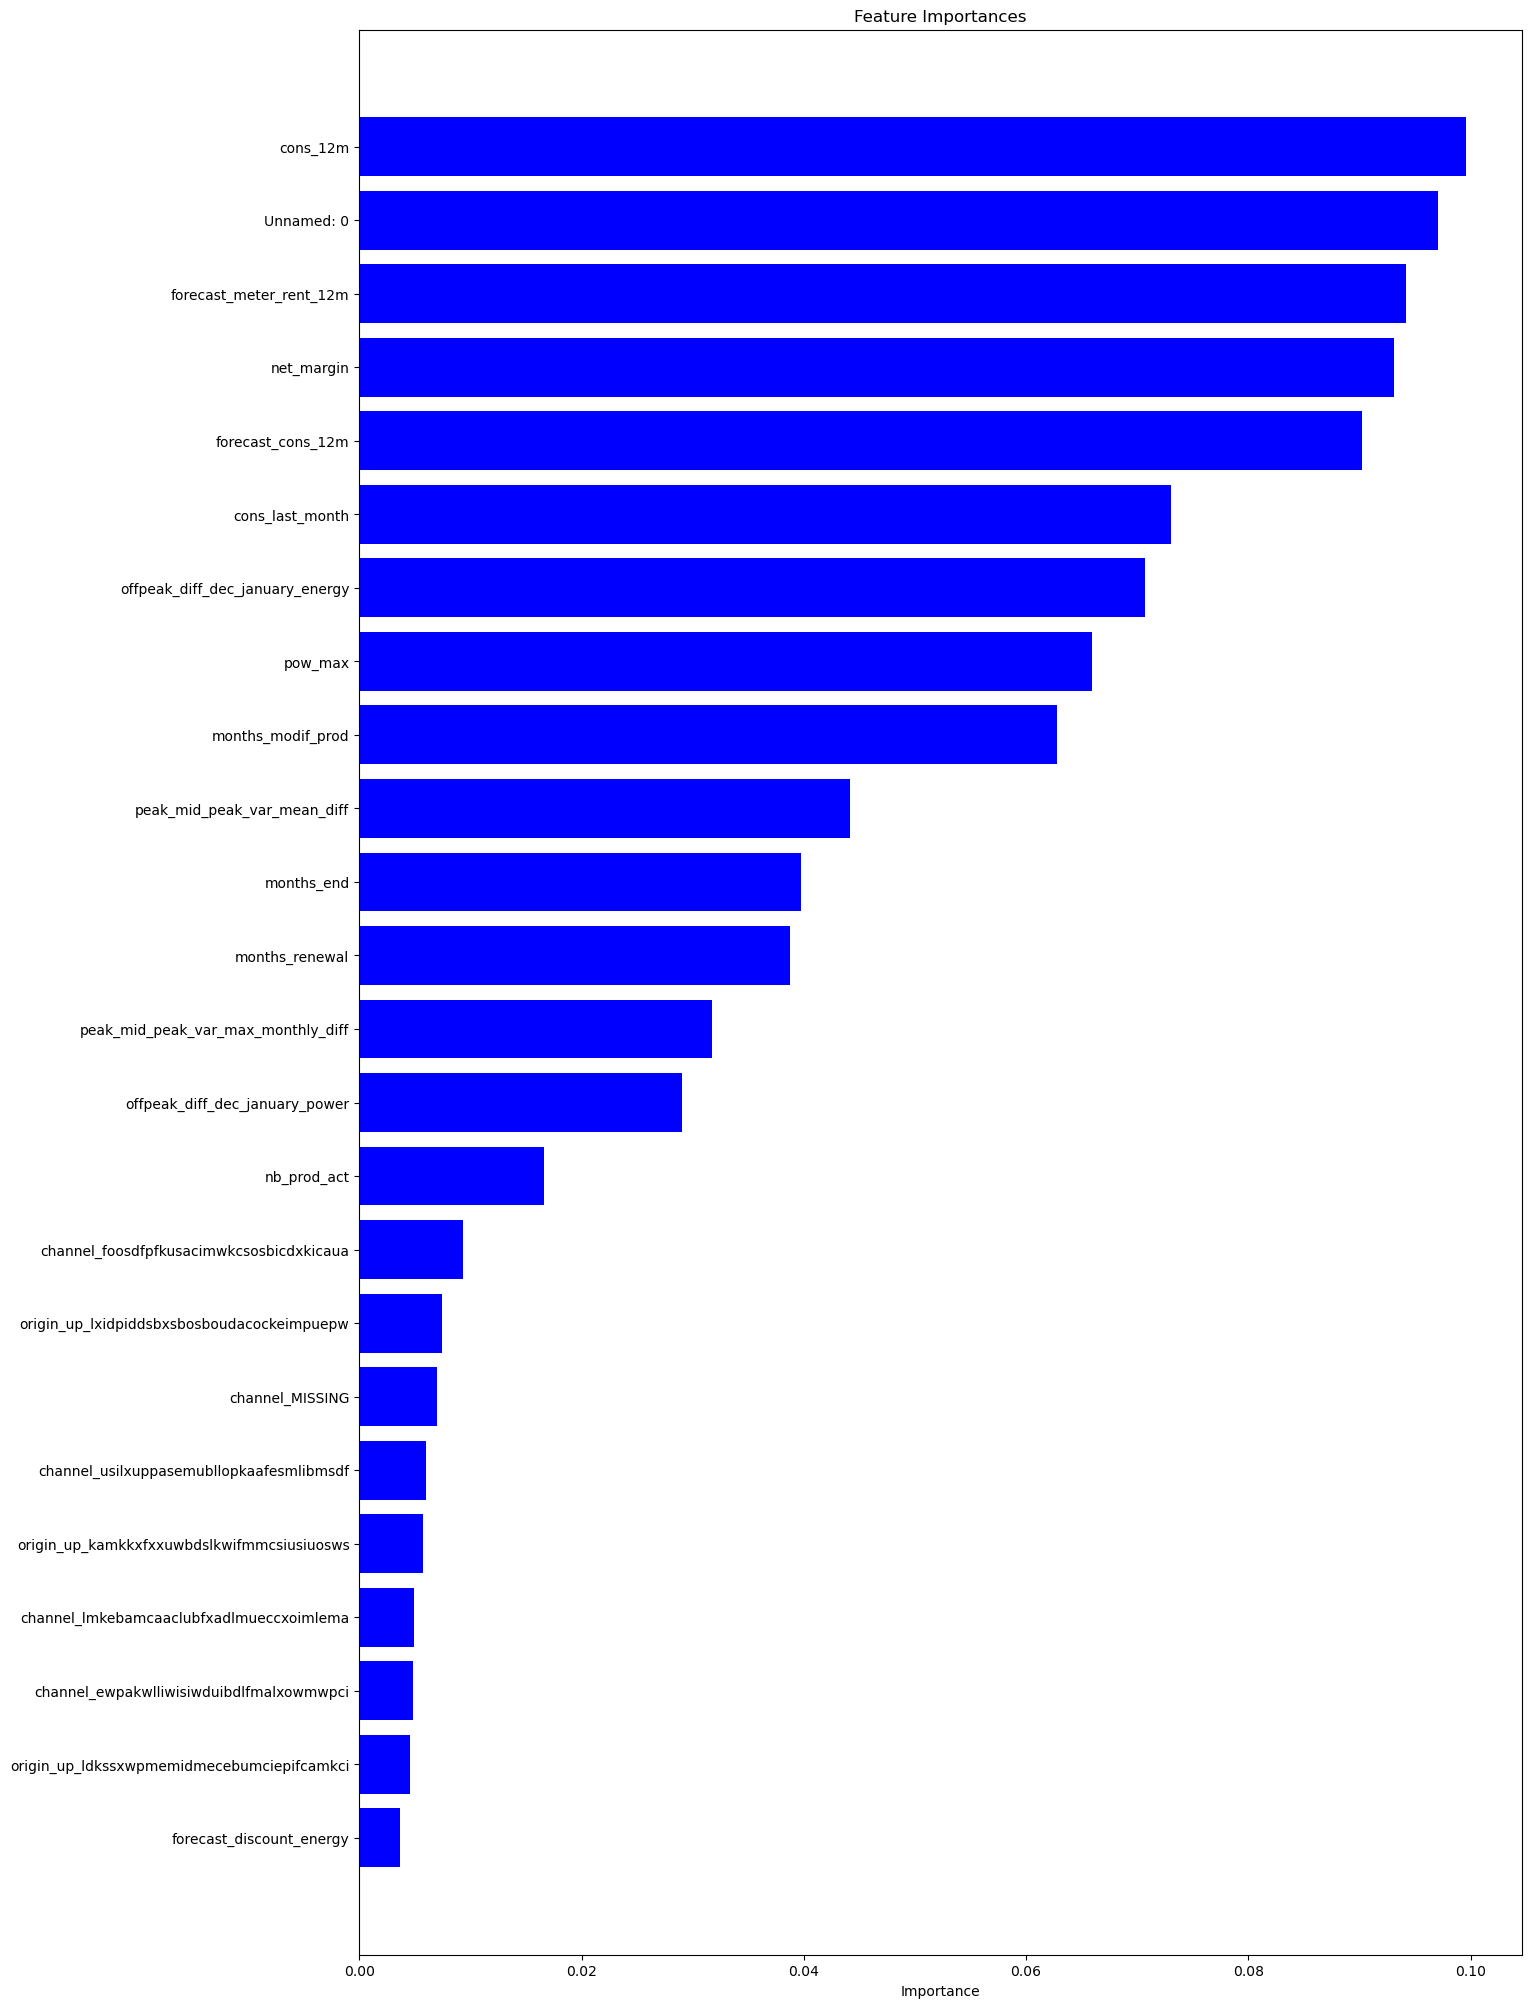

In [119]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

We observed: 
- consumption over 12 months, consumption in the last month, and net margin are top drivers for churn in this model
- difference between December and January off peak price is also infleuncial
- price sensitivity does not seem to play to large role

In [120]:
proba_predictions = rfc.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [121]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [123]:
X_test['churn'] = y_pred.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')